In [1]:
# falta ultima parte

In [2]:
# 10/03/2022 Luís

# In this notebook, in addition to the "train_HGO_diff" notebook,
# the parameters [c, κ, k1, k2, θ] were normalized using sklearn.preprocessing.StandardScaler()
# This way, each of the components of the vector is normaly distributed around 0 with a standard deviation of 1.

# For example, for c, mean = 20.59518917 and std = 12.4038047.
# A original value of 13.78172437 will be transformed into -0.54930442. (z = (x – mean) / std)

# Lower losses were achieved with this normalization.



# 28/03/2022 Luís

# In this notebook I use a total set of 537824 (14^5) curves. The model only predicts the stress value, as the stretch values
# were the same for all curves.

# In the end of the notebook, the test labels and model outputs are transformed back into absolute coordinates
# (the model is trained on the differences between stress values) and I apply evaluation metrics to the model.

# Three metrics are applied: 

# MSE (average error across all test curves)

# R^2 score (average score across all test curves)
#           (accuracy score defined as the percentage of curves that have a score above an accepteble treshold)

# Relative error (average error across all test curves)
#                (accuracy score defined as the percentage of curves that have an error below an accepteble treshold)

# I have a spreadsheet with these metrics applied on similar models which were trained on 10^5; 12^5; 14^5 and 16^5 curves.

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import ast
import seaborn as sns
from sklearn.model_selection import train_test_split

2022-04-18 16:48:23.207837: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [5]:
import pandas as pd
import random

#import sympy as sym
#from sympy.physics.quantum import TensorProduct

import numpy as np
from matplotlib import pyplot as plt

#pd.set_option('display.max_rows', None)

In [6]:
from sklearn import preprocessing
from sklearn.metrics import r2_score

In [7]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
  plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show() 

### Import data

#### In this case we have 537824 total curves (= 14^5)

In [8]:
X = np.load('X_14_20.npy')
y = np.load('y_14_20.npy')

In [9]:
ninc = np.shape(y)[1] # number of points per curve, in this case ninc = 10

### Remove curves in which there are negative stress values

In [10]:
print(np.shape(y)[0], "initial total curves")

537824 initial total curves


In [11]:
y_stress_xx = y[:,:,1]

unq, count = np.unique(np.where(y_stress_xx>=0)[0], axis=0, return_counts=True)
i_positive_xx = unq[count>8]

y_stress_yy = y[:,:,2]

unq, count = np.unique(np.where(y_stress_yy>=0)[0], axis=0, return_counts=True)
i_positive_yy = unq[count>8]

i_positive = np.unique(np.ndarray.flatten(np.array([i_positive_xx,i_positive_yy])))

X = X[i_positive]
y = y[i_positive]

In [12]:
print(len(i_positive), "remaining curves")

537824 remaining curves


### We will normalize X now

In [13]:
print(X[0])  # Parameters for curve 0 before transformation

[19.92178319  0.32272105  4.62345312  3.32968143  4.01515236]


In [14]:
print(np.average(X, axis = 0))

[20.53305232  0.21684653  2.55514319  2.55514148 45.467038  ]


In [15]:
print(np.std(X, axis = 0))

[12.09111645  0.07219331  1.51750793  1.51732259 27.26201399]


In [16]:
# Normalization of the input data
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [17]:
print(X[0])  # Parameters for curve 0 after transformation

[-0.05055523  1.46654184  1.36296483  0.51046491 -1.52049976]


### Next we will transform y such that it will contain the differences between its successive elements.

In [18]:
y[0] # curve 0 before transformation

array([[ 1.        ,  0.        ,  0.        ],
       [ 1.03157895,  3.61083755,  3.6126096 ],
       [ 1.06315789,  6.94327637,  6.94925765],
       [ 1.09473684, 10.05964723, 10.07241165],
       [ 1.12631579, 13.01029598, 13.03264459],
       [ 1.15789474, 15.83715309, 15.8722661 ],
       [ 1.18947368, 18.57675782, 18.62842625],
       [ 1.22105263, 21.26301087, 21.33597561],
       [ 1.25263158, 23.92996601, 24.03041046],
       [ 1.28421053, 26.61506445, 26.75133841],
       [ 1.31578947, 29.36339481, 29.5470987 ],
       [ 1.34736842, 32.23388942, 32.48153442],
       [ 1.37894737, 35.30896903, 35.64457756],
       [ 1.41052632, 38.71025869, 39.16953186],
       [ 1.44210526, 42.62507765, 43.26222878],
       [ 1.47368421, 47.35237455, 48.25160087],
       [ 1.50526316, 53.38452007, 54.67973596],
       [ 1.53684211, 61.55683876, 63.46649808],
       [ 1.56842105, 73.32849396, 76.21871316],
       [ 1.6       , 91.32525234, 95.82752683]])

In [19]:
np.shape(y)

(537824, 20, 3)

#### We will not use the stretch values in this model as input of our model. They will be saved in a vector (x_vec), as they are the same for every curve.

In [20]:
x_vec = np.array(y[0,:,0])
x_vec

array([1.        , 1.03157895, 1.06315789, 1.09473684, 1.12631579,
       1.15789474, 1.18947368, 1.22105263, 1.25263158, 1.28421053,
       1.31578947, 1.34736842, 1.37894737, 1.41052632, 1.44210526,
       1.47368421, 1.50526316, 1.53684211, 1.56842105, 1.6       ])

In [21]:
for i in range(len(y)):
    y_diff = np.zeros(np.shape(y[0]))
    for j in range(len(y[0])-1):
        y_diff[j+1] = y[i][j+1]-y[i][j]
    #y_diff[0] = [1,0]
    y[i] = y_diff

y = y[:,1:,1:]
    
y[0] # curve 0 after transformation

array([[ 3.61083755,  3.6126096 ],
       [ 3.33243883,  3.33664805],
       [ 3.11637086,  3.123154  ],
       [ 2.95064875,  2.96023294],
       [ 2.82685712,  2.83962151],
       [ 2.73960472,  2.75616015],
       [ 2.68625305,  2.70754936],
       [ 2.66695514,  2.69443485],
       [ 2.68509844,  2.72092795],
       [ 2.74833036,  2.79576029],
       [ 2.87049461,  2.93443572],
       [ 3.07507961,  3.16304314],
       [ 3.40128966,  3.5249543 ],
       [ 3.91481896,  4.09269692],
       [ 4.7272969 ,  4.98937209],
       [ 6.03214552,  6.42813509],
       [ 8.1723187 ,  8.78676212],
       [11.77165519, 12.75221508],
       [17.99675838, 19.60881367]])

In [22]:
np.shape(y)

(537824, 19, 2)

### Now we are ready to seperate our data into a training set and a test set

In [153]:
#let's save 10% of the data for testing. these curves won't be part of the model training 
test_split=0.1
x_train, x_test,y_train,y_test = train_test_split(X, y, test_size = test_split)
#let's check the array shapes: 
print('Input data')
print('Training set: ',x_train.shape)
print('Test set: ',x_test.shape)
print(' ')
print('Features')
print('Training set: ',y_train.shape)
print('Test set: ',y_test.shape)

#reshape for keras training
#y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
#y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))
#shuffle data
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]


Input data
Training set:  (484041, 5)
Test set:  (53783, 5)
 
Features
Training set:  (484041, 19, 2)
Test set:  (53783, 19, 2)


In [154]:
np.shape(x_train)

(484041, 5)

In [155]:
np.shape(y_train)

(484041, 19, 2)

### And now we can build our model and train it

In [156]:
# Set the hyperparameters
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 0.00002
BATCH_SIZE = 256
EPOCHS = 50
INPUT_SHAPE = x_train.shape[1:]
OUTPUT_SHAPE = y_train.shape[1:]

# Set the model's architechture
inputs = keras.Input(shape=INPUT_SHAPE)

dense = layers.Dense(512, activation="relu")
x = dense(inputs)

#dense = layers.Dense(1024, activation="relu")
#x = dense(x)

#dense = layers.Dense(1024, activation="relu")
#x = dense(x)

dense = layers.Dense((ninc-1)*40, activation="relu")
x = dense(x)

dropout = tf.keras.layers.Dropout(0.2)
x = dropout(x)

x = tf.keras.layers.Reshape((ninc-1, -1))(x)

dense = layers.Dense(1024, activation="relu")
x = dense(x)

dense = layers.Dense(1024, activation="relu")
x = dense(x)

dense = layers.Dense(1024, activation="relu")
x = dense(x)

dropout = tf.keras.layers.Dropout(0.2)
x = dropout(x)

outputs = layers.Dense(2)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="model")


# Compile, define the loss function, the optimizer and other metrics
model.compile(
    loss = tf.keras.losses.Huber(),
   # optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE, decay = LEARNING_RATE/EPOCHS),
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=["mean_squared_error"],
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_41 (Dense)             (None, 1024)              6144      
_________________________________________________________________
dense_42 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_43 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_44 (Dense)             (None, 760)               779000    
_________________________________________________________________
dropout_11 (Dropout)         (None, 760)               0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 19, 40)            0     

In [157]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history=model.fit(
    x_train,
    y_train,
    validation_split=VALIDATION_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
)

test_loss, test_acc = model.evaluate(x_test, y_test)

#print("Test accuracy", test_acc)
print("Test loss", test_loss)

Epoch 1/50
1513/1513 [==============================] - 11s 7ms/step - loss: 46.2718 - mean_squared_error: 1020816.5000 - val_loss: 36.8683 - val_mean_squared_error: 798801.2500
Epoch 2/50
1513/1513 [==============================] - 11s 7ms/step - loss: 33.7372 - mean_squared_error: 676093.5000 - val_loss: 31.6487 - val_mean_squared_error: 630158.0625
Epoch 3/50
1513/1513 [==============================] - 11s 7ms/step - loss: 29.4371 - mean_squared_error: 557255.8125 - val_loss: 28.2401 - val_mean_squared_error: 559821.3750
Epoch 4/50
1513/1513 [==============================] - 11s 8ms/step - loss: 25.9853 - mean_squared_error: 497912.1562 - val_loss: 21.5576 - val_mean_squared_error: 469863.1250
Epoch 5/50
1513/1513 [==============================] - 10s 7ms/step - loss: 17.8628 - mean_squared_error: 358929.7812 - val_loss: 12.1807 - val_mean_squared_error: 259750.1094
Epoch 6/50
1513/1513 [==============================] - 11s 7ms/step - loss: 12.7285 - mean_squared_error: 207725.

30.39775013923645


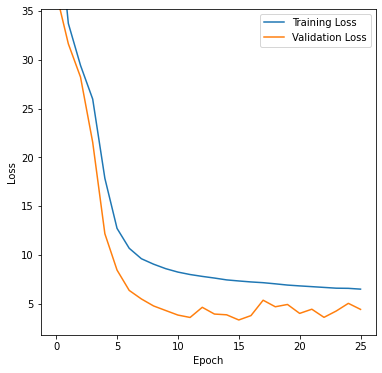

In [158]:
plt.rcParams["figure.figsize"] = (6,6)

epochs = history.epoch

hist = history.history

plot_the_loss_curve(epochs, hist["loss"], 
                    hist["val_loss"])

In [159]:
model.predict(x_test[0:1])[0]

array([[ 3.4753444,  3.4911876],
       [ 3.1550546,  3.1440516],
       [ 3.038243 ,  3.3513212],
       [ 2.985255 ,  3.091004 ],
       [ 2.8596032,  3.1359503],
       [ 3.0788937,  3.1458097],
       [ 3.011786 ,  3.2392993],
       [ 3.0493152,  3.4925995],
       [ 2.9260576,  3.080063 ],
       [ 2.962999 ,  3.909717 ],
       [ 3.2211246,  4.1312838],
       [ 2.986351 ,  4.267155 ],
       [ 3.4223127,  5.676488 ],
       [ 4.0479345,  6.7940125],
       [ 4.4199347,  7.553411 ],
       [ 4.728641 , 10.048817 ],
       [ 5.57402  , 12.826252 ],
       [ 7.634549 , 15.194527 ],
       [ 8.739923 , 22.468292 ]], dtype=float32)

In [160]:
y_test[0:1][0]

array([[ 3.73886931,  3.94263192],
       [ 3.46235413,  3.7158666 ],
       [ 3.24391961,  3.55469342],
       [ 3.07389182,  3.45245422],
       [ 2.94523605,  3.40609162],
       [ 2.85311907,  3.41606227],
       [ 2.79467262,  3.48661648],
       [ 2.76894349,  3.62650562],
       [ 2.77704172,  3.85024592],
       [ 2.82252878,  4.18016381],
       [ 2.91212962,  4.64959459],
       [ 3.05691469,  5.30783962],
       [ 3.27419715,  6.22786692],
       [ 3.590553  ,  7.51837088],
       [ 4.0466448 ,  9.34287269],
       [ 4.70499766, 11.95037144],
       [ 5.66269098, 15.7252434 ],
       [ 7.07237301, 21.269733  ],
       [ 9.17760569, 29.54254611]])

In [161]:
np.shape(model.predict(x_test[0:1])[0])

(19, 2)

In [162]:
x_vec

array([1.        , 1.03157895, 1.06315789, 1.09473684, 1.12631579,
       1.15789474, 1.18947368, 1.22105263, 1.25263158, 1.28421053,
       1.31578947, 1.34736842, 1.37894737, 1.41052632, 1.44210526,
       1.47368421, 1.50526316, 1.53684211, 1.56842105, 1.6       ])

In [163]:
def plot_real_curves(k):
    
    pred_diff = model.predict(x_test[k:k+1])[0][:,0]
    pred = np.zeros([len(pred_diff)+1])
    pred[0] = 0
    for i in range(len(pred_diff)):
        pred[i+1] = pred_diff[i] + pred[i]

    plt.plot(x_vec,pred, "--",  color = "g", label = "prediction_xx")

    
    true_dif = y_test[k:k+1][0][:,0]
    true = np.zeros([len(true_dif)+1])
    true[0] = 0
    for i in range(len(pred_diff)):
        true[i+1] = true_dif[i] + true[i]

    plt.plot(x_vec,true, color = "g", label = "real_xx")

    pred_diff = model.predict(x_test[k:k+1])[0][:,1]
    pred = np.zeros([len(pred_diff)+1])
    pred[0] = 0
    for i in range(len(pred_diff)):
        pred[i+1] = pred_diff[i] + pred[i]

    plt.plot(x_vec,pred, "--",  color = "r", label = "prediction_yy")

    
    true_dif = y_test[k:k+1][0][:,1]
    true = np.zeros([len(true_dif)+1])
    true[0] = 0
    for i in range(len(pred_diff)):
        true[i+1] = true_dif[i] + true[i]

    plt.plot(x_vec,true, color = "r", label = "real_yy")

    plt.xlabel("λ")
    plt.ylabel("σ")
    plt.legend()
    plt.show()

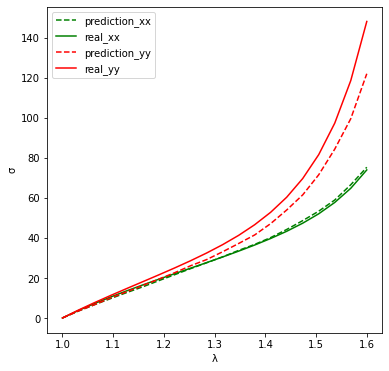

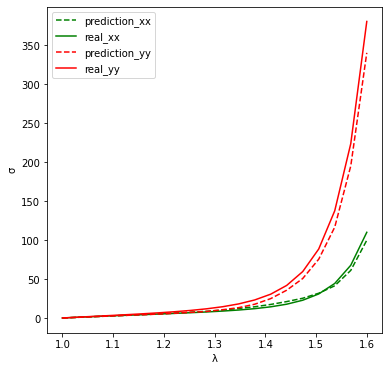

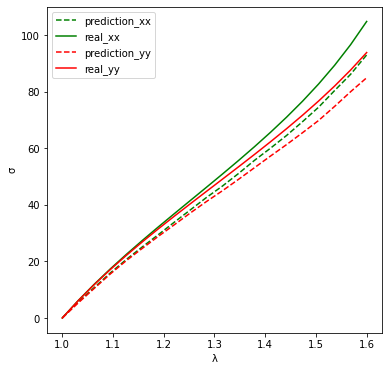

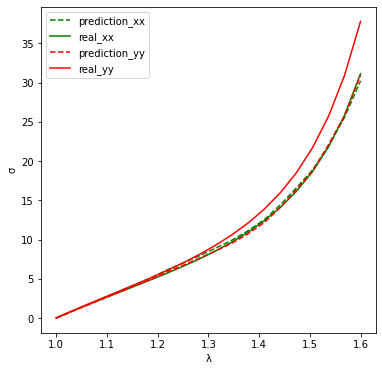

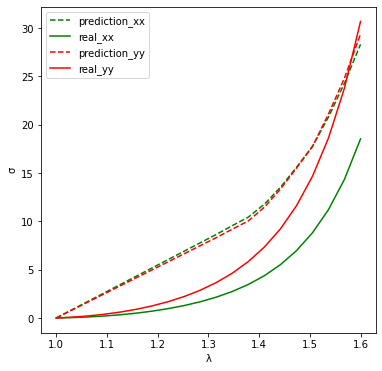

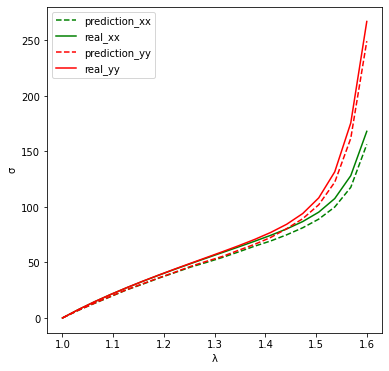

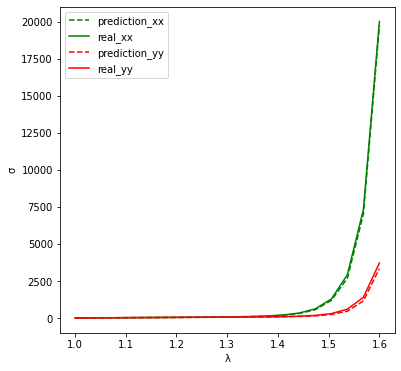

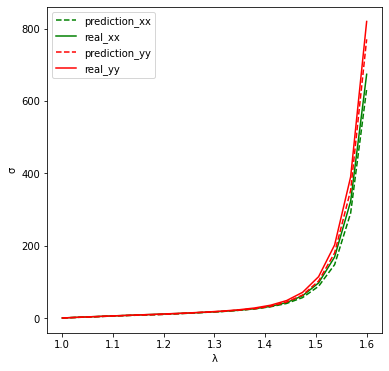

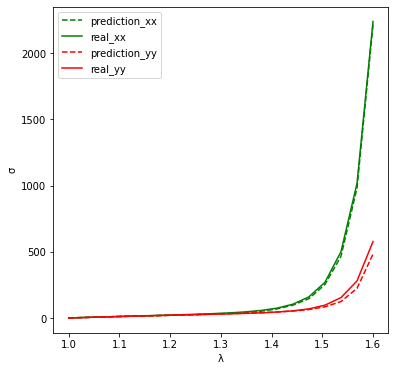

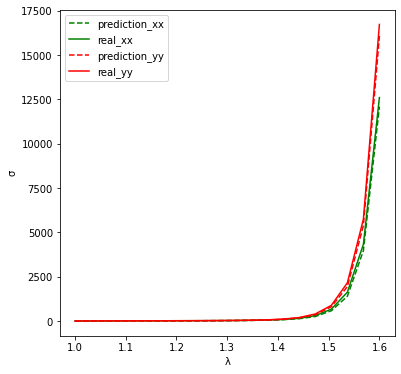

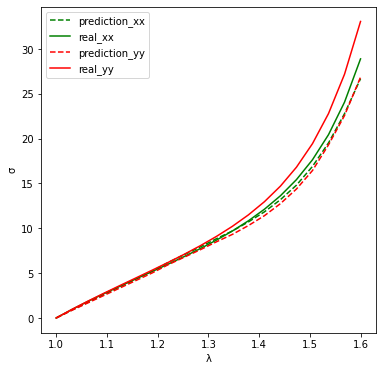

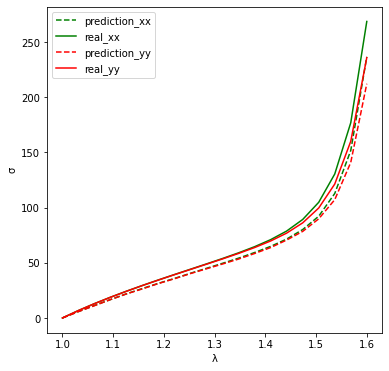

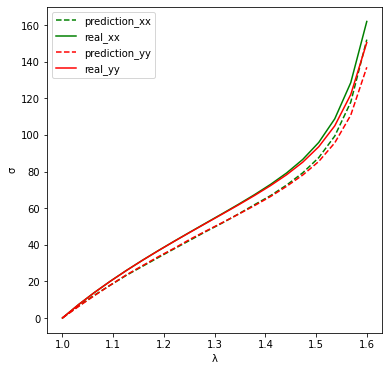

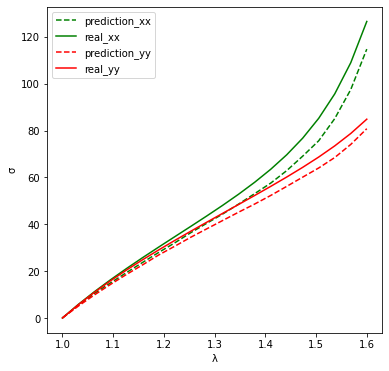

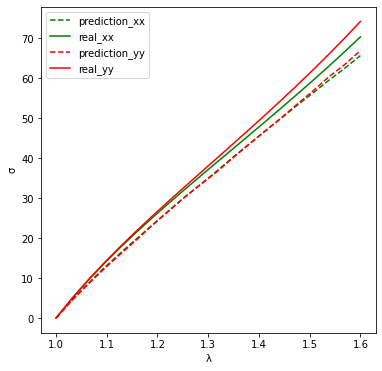

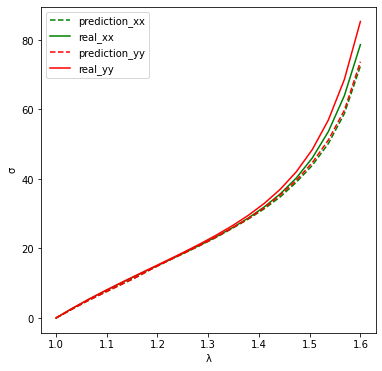

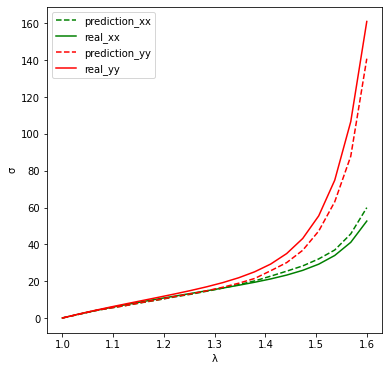

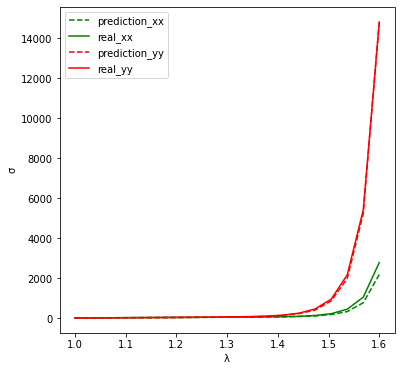

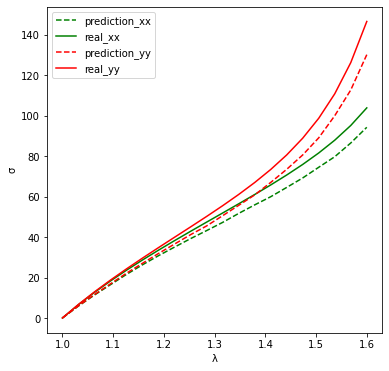

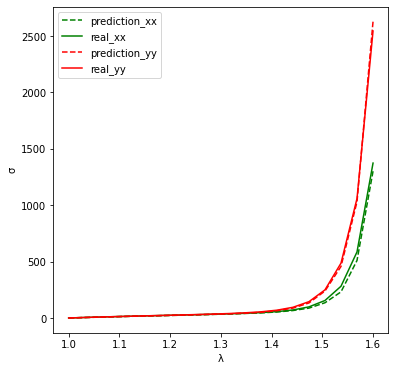

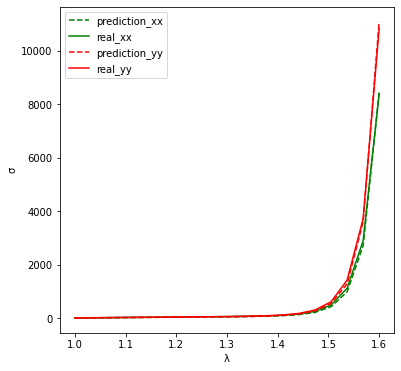

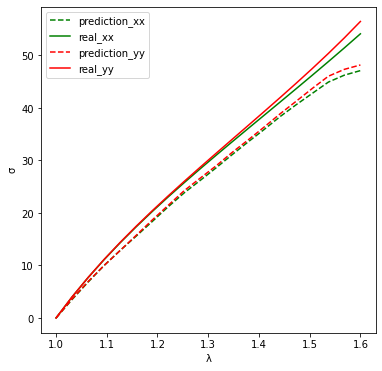

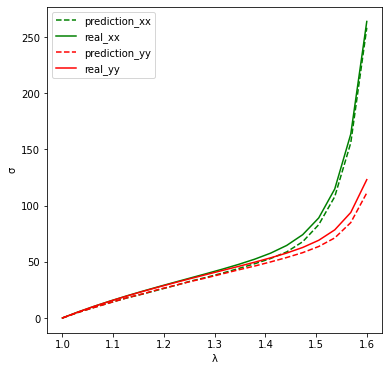

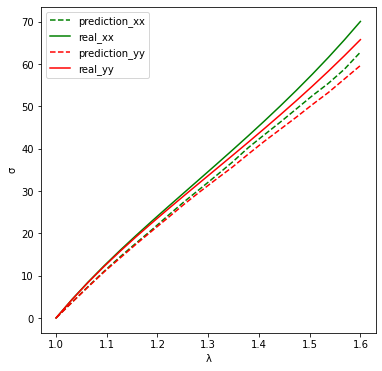

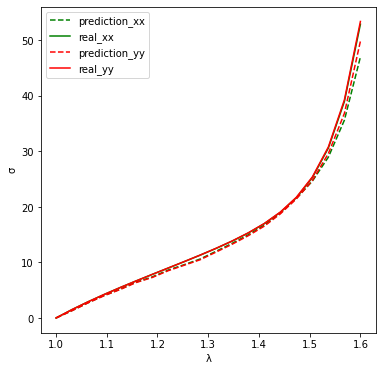

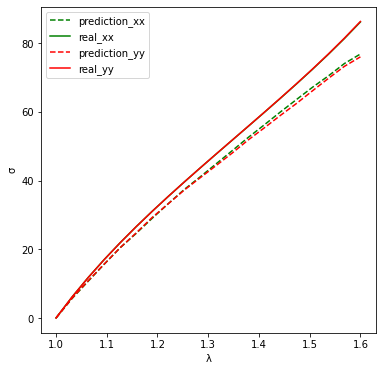

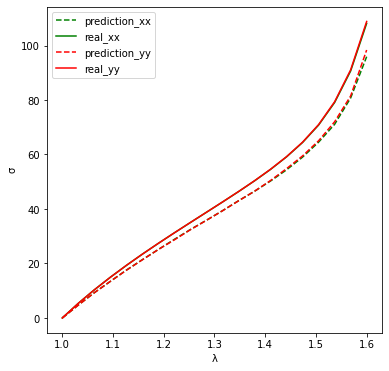

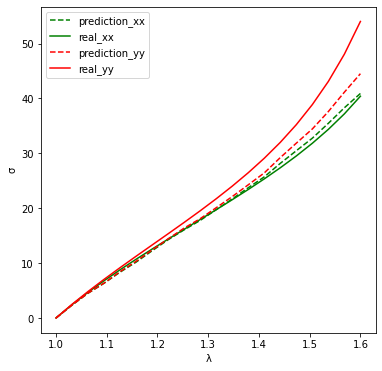

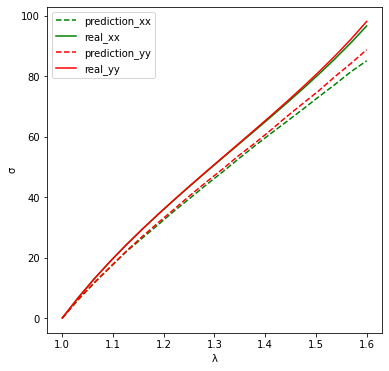

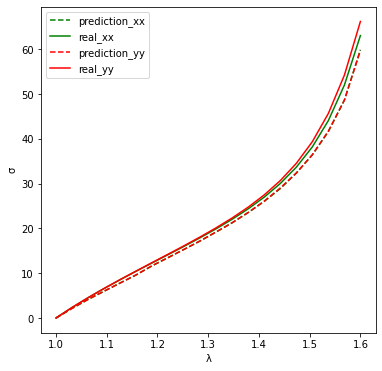

In [164]:
for i in range(30): plot_real_curves(i)

In [165]:
def rel_error(true,guess):
    err = np.abs(true-guess)/np.abs(true)
    return err

### Convert the curves used for testing back into absolute coordinates

In [166]:
def convert_back_curves(y_diff):
    ### Transforms the model's output (which is written in terms of differences between points) back into absolute coordinates.
    
    abs_curves = np.zeros([np.shape(y_diff)[0],np.shape(y_diff)[1]+1])    
    for i in range(len(y_diff)):
        y_abs = np.zeros(np.shape(y_diff)[1]+1)
        for j in range(len(y_diff[0])):
            y_abs[j+1] = y_diff[i][j]+y_abs[j]
        abs_curves[i] = y_abs
    
    return abs_curves

In [ ]:
pred_curves_xx = convert_back_curves(model.predict(x_test)[:,:,0])
true_curves_xx = convert_back_curves(y_test[:,:,0])

pred_curves_yy = convert_back_curves(model.predict(x_test)[:,:,1])
true_curves_yy = convert_back_curves(y_test[:,:,1])

### Model evaluation metrics applied on the test set of curves

In [ ]:
print("XX DIRECTION")
print('\n')

# RELATIVE ERROR CRITERIA
c = np.average(rel_error(true_curves_xx[:,1:], pred_curves_xx[:,1:]),axis = 1)

print("Average relative error", np.round(np.average(c)*100,decimals = 2),"%")

treshold = 0.05
treshold2 = 0.10
print("Relative error accuracy =",np.round(100*len(c[c<treshold])/len(c), decimals = 2),"%, for a treshold of",treshold*100,"%")
print("Relative error accuracy =",np.round(100*len(c[c<treshold2])/len(c), decimals = 2),"%, for a treshold of",treshold2*100,"%")
print('\n')

# R^2 SCORE CRITERIA
d = r2_score(np.transpose(true_curves_xx[:,1:]), np.transpose(pred_curves_xx[:,1:]), multioutput='raw_values')

print("Average R^2 score: ", np.round(np.average(d),decimals = 4))

treshold = 0.95
print("R^2 Accuracy =", np.round(100*len(d[d>treshold])/len(d),decimals=2), "%, for a treshold of", treshold)
print('\n')

# MSE CRITERIA
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
e = mse(true_curves_xx[:,1:], pred_curves_xx[:,1:]).numpy()

print("Average MSE score: ", np.round(np.average(e),decimals = 2),'\n')

print("Average RMSE score: ", np.round(np.sqrt(np.average(e)),decimals=2),'\n')

# MAE CRITERIA
mae = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
f = mae(true_curves_xx[:,1:], pred_curves_xx[:,1:]).numpy()

print("Average MAE score: ", np.round(np.average(f),decimals = 2),'\n')

c_xx = c
d_xx = d
e_xx = e
f_xx = f

XX DIRECTION


Average relative error 26.38 %
Relative error accuracy = 13.81 %, for a treshold of 5.0 %


Average R^2 score:  -0.6425
R^2 Accuracy = 86.22 %, for a treshold of 0.95


Average MSE score:  11481.27 

Average RMSE score:  107.15 

Average MAE score:  8.4 



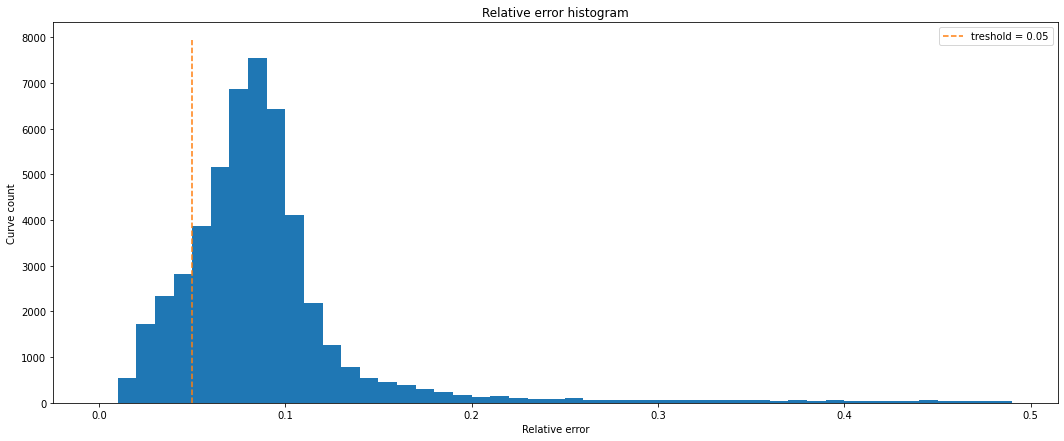

In [ ]:
BINS = np.arange(0,0.5,0.01)

plt.rcParams["figure.figsize"] = (18,7)
fig=plt.hist(c, bins = BINS,rwidth=1)

m = np.max(np.histogram(c, bins = BINS)[0]) + 0.05*np.max(np.histogram(c, bins = BINS)[0])

plt.plot([0.05,0.05],[0,m], '--', label = "treshold = 0.05")

plt.ylabel("Curve count")
plt.xlabel("Relative error")
plt.title("Relative error histogram")

plt.legend()
plt.show()

No handles with labels found to put in legend.


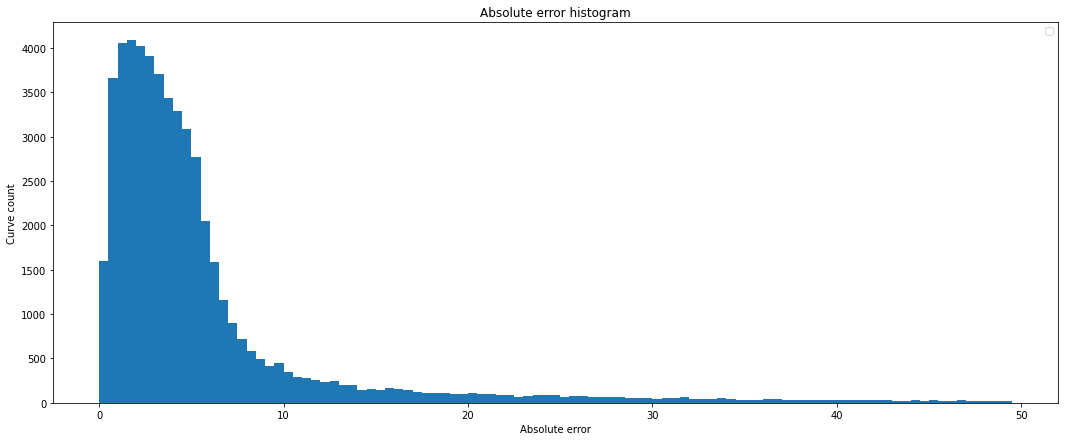

In [ ]:
BINS = np.arange(0.0,30.0,0.5)

plt.rcParams["figure.figsize"] = (18,7)
fig=plt.hist(f, bins = BINS,rwidth=1)

plt.ylabel("Curve count")
plt.xlabel("Absolute error")
plt.title("Absolute error histogram")

plt.legend()
plt.show()

In [ ]:
print("YY DIRECTION")
print('\n')

# RELATIVE ERROR CRITERIA
c = np.average(rel_error(true_curves_yy[:,1:], pred_curves_yy[:,1:]),axis = 1)

print("Average relative error", np.round(np.average(c)*100,decimals = 2),"%")

treshold = 0.05
treshold2 = 0.10
print("Relative error accuracy =",np.round(100*len(c[c<treshold])/len(c), decimals = 2),"%, for a treshold of",treshold*100,"%")
print("Relative error accuracy =",np.round(100*len(c[c<treshold2])/len(c), decimals = 2),"%, for a treshold of",treshold2*100,"%")
print('\n')

# R^2 SCORE CRITERIA
d = r2_score(np.transpose(true_curves_yy[:,1:]), np.transpose(pred_curves_yy[:,1:]), multioutput='raw_values')

print("Average R^2 score: ", np.round(np.average(d),decimals = 4))

treshold = 0.95
print("R^2 Accuracy =", np.round(100*len(d[d>treshold])/len(d),decimals=2), "%, for a treshold of", treshold)
print('\n')

# MSE CRITERIA
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
e = mse(true_curves_yy[:,1:], pred_curves_yy[:,1:]).numpy()

print("Average MSE score: ", np.round(np.average(e),decimals = 2),'\n')

print("Average RMSE score: ", np.round(np.sqrt(np.average(e)),decimals=2),'\n')

# MAE CRITERIA
mae = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
f = mae(true_curves_yy[:,1:], pred_curves_yy[:,1:]).numpy()

print("Average MAE score: ", np.round(np.average(f),decimals = 2),'\n')

c_yy = c
d_yy = d
e_yy = e
f_yy = f

YY DIRECTION


Average relative error 25.53 %
Relative error accuracy = 15.96 %, for a treshold of 5.0 %


Average R^2 score:  -0.4881
R^2 Accuracy = 86.87 %, for a treshold of 0.95


Average MSE score:  17771.33 

Average RMSE score:  133.31 

Average MAE score:  8.34 



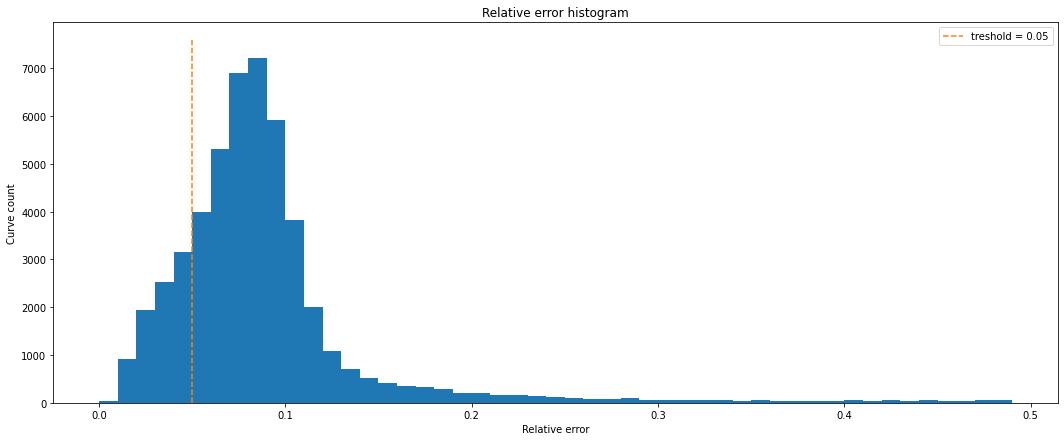

In [ ]:
BINS = np.arange(0,0.5,0.01)

plt.rcParams["figure.figsize"] = (18,7)
fig=plt.hist(c, bins = BINS,rwidth=1)

m = np.max(np.histogram(c, bins = BINS)[0]) + 0.05*np.max(np.histogram(c, bins = BINS)[0])

plt.plot([0.05,0.05],[0,m], '--', label = "treshold = 0.05")

plt.ylabel("Curve count")
plt.xlabel("Relative error")
plt.title("Relative error histogram")

plt.legend()
plt.show()

In [ ]:
BINS = np.arange(0.0,30.0.0,0.5)

plt.rcParams["figure.figsize"] = (18,7)
fig=plt.hist(f, bins = BINS,rwidth=1)

plt.ylabel("Curve count")
plt.xlabel("Absolute error")
plt.title("Absolute error histogram")

plt.legend()
plt.show()

In [ ]:
print("AVERAGE OF XX AND YY DIRECTIONS")
print('\n')

# RELATIVE ERROR CRITERIA
c = (c_xx + c_yy)/2

print("Average relative error", np.round(np.average(c)*100,decimals = 2),"%")

treshold = 0.05
treshold2 = 0.10
print("Relative error accuracy =",np.round(100*len(c[c<treshold])/len(c), decimals = 2),"%, for a treshold of",treshold*100,"%")
print("Relative error accuracy =",np.round(100*len(c[c<treshold2])/len(c), decimals = 2),"%, for a treshold of",treshold2*100,"%")
print('\n')

# R^2 SCORE CRITERIA
d = (d_xx + d_yy)/2

print("Average R^2 score: ", np.round(np.average(d),decimals = 4))

treshold = 0.95
print("R^2 Accuracy =", np.round(100*len(d[d>treshold])/len(d),decimals=2), "%, for a treshold of", treshold)
print('\n')

# MSE CRITERIA
e = (e_xx + e_yy)/2

print("Average MSE score: ", np.round(np.average(e),decimals = 2),'\n')

print("Average RMSE score: ", np.round(np.sqrt(np.average(e)),decimals=2),'\n')

# MAE CRITERIA
f = (f_xx + f_yy)/2

print("Average MAE score: ", np.round(np.average(f),decimals = 2),'\n')

In [ ]:
BINS = np.arange(0,0.5,0.01)

plt.rcParams["figure.figsize"] = (18,7)
fig=plt.hist(c, bins = BINS,rwidth=1)

m = np.max(np.histogram(c, bins = BINS)[0]) + 0.05*np.max(np.histogram(c, bins = BINS)[0])

plt.plot([0.05,0.05],[0,m], '--', label = "treshold = 0.05")

plt.ylabel("Curve count")
plt.xlabel("Relative error")
plt.title("Relative error histogram")

plt.legend()
plt.show()

In [ ]:
BINS = np.arange(0.0,30.0.0,0.5)

plt.rcParams["figure.figsize"] = (18,7)
fig=plt.hist(f, bins = BINS,rwidth=1)

plt.ylabel("Curve count")
plt.xlabel("Absolute error")
plt.title("Absolute error histogram")

plt.legend()
plt.show()